
**Initialization**

In [1]:
import seaborn as sns
import os
import networkx as nx
from pprint import pprint
import pandas as pd
import numpy as np
import random
import math as m
import glob
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
from grave import plot_network
basedir = '../results'
from tqdm.notebook import tqdm
def giant_component(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, max(nx.connected_components(g), key=len))

from scipy.stats import t
def ci(series):
    return series.sem()*t.ppf((1 + 0.95) / 2., len(series)-1)

def to_csv_comment(df, path):
    with open(path, 'w') as fr:
        fr.write('#'+df.to_csv())

/tmp/ipykernel_3309399/2691174795.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


**Read Data**

In [2]:
##Read all the graphs
import re
# re.split('; |, |\*|\n',a)
graphs = []
#
files = glob.glob(f'{basedir}/*/*.wireless.graphml.gz')

for f in files:
    w_g = nx.read_graphml(f)
    f_g = nx.read_graphml(f.replace('wireless', 'fiber'))
    n_cust = sum([w_g.nodes[n]['subscriptions'] for n in w_g.nodes() if w_g.degree()[n] > 0])
    graphs.append((f.replace(basedir, ''),w_g,f_g,n_cust))


**Simple Metrics**

In [3]:
def average_path_length(graph: nx.Graph):
    gws = [n for n in graph if 'type' in graph.nodes[n] and graph.nodes[n]['type'] == 'gateway']
    plenghts = nx.multi_source_dijkstra_path_length(graph, gws)
    lengths = np.array(list(plenghts.values()))

    return lengths.mean(), lengths.max()

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    measures['nodes'] = len(w_g)
    measures['subscriptions'] = n_subs
    measures['edges'] = len(w_g.edges())
    measures['avg_pathl'], measures['max_pathl'] = average_path_length(w_g)
    measures['area'] = area
    measures['ratio'] = int(ratio)
    measures['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
    measures['leaves'] = len([n for n in w_g.nodes() if w_g.degree()[n]==1])
    measures['relays'] = len([n for n in w_g.nodes() if w_g.degree()[n]>1]) - measures['gateways']
    measures['relays_ratio'] =  measures['relays']/n_subs
    unc = sum([d['subscriptions'] for n, d in w_g.nodes(data=True) if w_g.degree()[n] == 0])
    all_sub = sum([d['subscriptions'] for n, d in w_g.nodes(data=True)])
    measures['unconnected'] = unc/all_sub
    measures['cluster_size'] = int(cluster_size)
    measures['time'] = time
    measures['seed'] = random_seed
    data.append(measures)
        
df = pd.DataFrame(data)


In [39]:
df.groupby(['cluster_size','ratio', ]).mean()

nodes  subscriptions    edges  avg_pathl  max_pathl  \
cluster_size ratio                                                          
50           20     247.222        288.182  222.390   1.281619      3.874   
             25     296.274        366.290  270.446   1.259288      3.872   
             50     496.008        733.462  452.680   1.222073      4.016   
             100    763.404       1436.106  678.990   1.207917      4.224   
100          20     247.204        289.162  224.468   1.379905      4.116   
             25     296.388        361.258  269.848   1.384857      4.344   
             50     496.082        743.334  465.622   1.303376      4.404   
             100    763.390       1493.596  717.288   1.250168      4.426   
200          20     247.278        291.976  228.468   1.627698      4.706   
             25     296.616        369.114  277.390   1.625663      4.774   
             50     495.996        733.114  459.614   1.448259      4.798   
             100    762.030       1500.302  723.502   1.340329      4.806   

                    gateways   leaves   relays  relays_ratio  unconnected  
cluster_size ratio                                                         
50           20        6.798  184.028   38.362      0.136228     0.101467  
             25        8.300  225.836   44.610      0.126746     0.080729  
             50       16.052  383.250   69.422      0.096403     0.070777  
             100      31.062  575.466  103.274      0.072266     0.069538  
100          20        3.700  182.606   41.862      0.151017     0.122606  
             25        4.400  220.592   49.256      0.142181     0.118088  
             50        8.300  389.192   76.430      0.107157     0.064158  
             100      16.070  607.920  109.368      0.075548     0.055898  
200          20        2.100  182.554   45.914      0.170903     0.098581  
             25        2.300  222.564   54.826      0.161031     0.079632  
             50        4.400  377.046   82.568      0.118995     0.099794  
             100       8.298  604.016  119.486      0.084067     0.055058

**CapEx**

In [40]:
import requests 
from pyproj import Proj, transform
inProj = Proj(init='epsg:3003')
outProj = Proj(init='epsg:4326')

## FIX MGB for each node
max_bx = 360   #max ch capacity at mcs8
contention_ratio = 50
mgb =  max_bx/contention_ratio
capex_costs = {
    'gateway_deploy': 10000, #cost to deploy trellis + works + permits
    'gateway_router': 5000, #Imaginary cool router
    'fiber_deploy': 6000, #per km (aerial)
    'relay_router': 500, #
    'relay_deploy':  1000, # cost for trellis +  works 
    'leaf_deploy': 300, #cost for roof installation
    'leaf_radio': 100,
    'mp_radio': 200
}
mpant_bw = 120
mchan = max_bx/contention_ratio
## Calculate shortest path towards closest GW.

def calc_cost_fiber(g):
    return sum([d['length'] for s,t,d in g.edges(data=True)])*1e-3*capex_costs['fiber_deploy']

def phi(g, n):
    #Find the size of the occupied beam and see how many antennas are needed to cover it.
    thisnode = g.nodes[n]
    beams = []
    for neigh in g[n]:
        thisneigh = g.nodes[neigh]
        beam = m.degrees(m.atan2(thisneigh['x'] - thisnode['x'], thisneigh['y']-thisnode['y'])) % 360
        beams.append(beam)
    beams.sort()
    try:
        beams.append(beams[0])
    except:
        print(g[n])
    beams = np.array(beams)
    
    diff = (beams[1:] - beams[:-1] -0.0001) % 360
    width = 360 - diff.max()    
    return width

def calc_antennas(g, n, gw):
    phi_v = m.ceil(phi(g, n)/mpant_bw)
    n_paths = sum([n['paths'] for n in g[n].values()])
    if not gw:
        #Relay nodes needs double of the BW
        k=2
    else: 
        k=1
    d_v = m.ceil(n_paths*k/contention_ratio)
    return max(phi_v, d_v)

    

def calc_cost_wireless(g) -> list[float]:
    for e in g.edges():
        g.edges[e]['paths'] = 0
    
    ## For each edge where a SP pass accumulate a value
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')
    for k,path in paths.items():
        n_subs = g.nodes(data=True)[k]['subscriptions']
        for i in range(len(path)-1):
            g.edges[path[i], path[i+1]]['paths'] += n_subs
                 
    ## Multiplicate the value by the BW needed for each node
    ## Calculate the cost of each edge
    for e in g.edges():
        if(g.edges[e]['paths'] == 0):
            ## For redundancy link assume a single path
            g.edges[e]['paths'] = 1
            g.edges[e]['redundant'] = 1
        else:
            g.edges[e]['redundant'] = 0
        g.edges[e]['bw'] = mgb * g.edges[e]['paths']

    for n in g.nodes():
        #If it's unconnected it does not cost
        if nx.degree(g)[n] == 0:
            g.nodes[n]['router_cost'] = 0
            g.nodes[n]['deploy'] = 0
            g.nodes[n]['fiber_cost'] = 0
            g.nodes[n]['radio_cost'] = 0
            continue
        #If it's a GW
        if g.nodes[n].get('type') == 'gateway':
            g.nodes[n]['router_cost'] = capex_costs['gateway_router'] 
            #loc = (g.nodes[n]['x'], g.nodes[n]['y'])
            #g.nodes[n]['fiber_cost' ] = capex_costs['fiber_deploy']*road_distance(fiber_points[area], loc)
            g.nodes[n]['deploy'] = capex_costs['gateway_deploy']
            g.nodes[n]['n_ant'] =  calc_antennas(g, n, True)
            #print(g.nodes[n]['n_ant'])
            g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
        else:
            g.nodes[n]['fiber_cost' ] = 0
            if g.degree()[n] == 1:
                #leaf node, no router
                g.nodes[n]['radio_cost'] = capex_costs['leaf_radio']
                g.nodes[n]['deploy'] = capex_costs['leaf_deploy']
                g.nodes[n]['router_cost'] = 0
                g.nodes[n]['n_ant'] = 1
            else:
                #relay node
                g.nodes[n]['n_ant'] = calc_antennas(g, n, False) 
                g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
                g.nodes[n]['deploy'] = capex_costs['relay_deploy']
                g.nodes[n]['router_cost'] = capex_costs['relay_router']
        
        
    router_cost = sum([g.nodes[n]['router_cost'] for n in g.nodes()])
    deploy = sum([g.nodes[n]['deploy'] for n in g.nodes()])
    radio_cost = sum([g.nodes[n]['radio_cost'] for n in g.nodes()])

    return [router_cost, deploy, radio_cost]
  

/home/gabriel/.virtualenvs/phigraph2/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/gabriel/.virtualenvs/phigraph2/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [41]:
data = []
data_summed = []
   
for (f,w_g,f_g, n_subs) in graphs:
    graph = w_g.copy()
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    costs = calc_cost_wireless(w_g)
    costs.append(calc_cost_fiber(f_g))
   
    type_costs = ['router_cost', 'deploy', 'radio_cost', 'fiber_cost']
    total_cost = sum(costs)
    data_summed.append({'capex': total_cost/n_subs/5/12,
                        'area': area, 
                        'cluster_size': cluster_size,
                        'ratio':ratio})

    for i in range(4):
        measures = {}
        measures['cost'] = costs[i]
        measures['cost_customer'] = costs[i]/n_subs
        measures['5ymontlycostcustomer'] = costs[i]/n_subs/5/12
        measures['type_cost'] = type_costs[i]
        measures['area'] = area
        measures['ratio'] = ratio
        measures['cluster_size'] = cluster_size
        measures['time'] = time
        measures['seed'] = random_seed
        data.append(measures)
        
edf = pd.DataFrame(data)
sedf = pd.DataFrame(data_summed)

(array([0, 1, 2, 3]),
 [Text(0, 0, '20'), Text(1, 0, '25'), Text(2, 0, '50'), Text(3, 0, '100')])

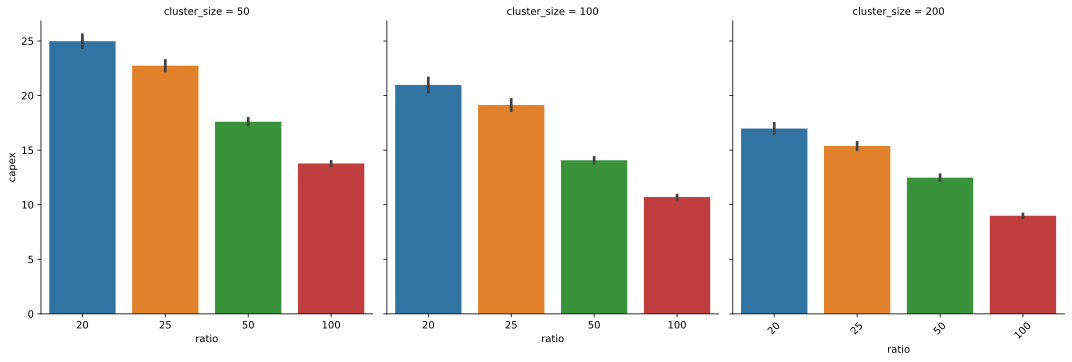

In [8]:
g = sns.catplot(data=sedf, 
            x='ratio',
            y='capex', 
            kind="bar", 
            col='cluster_size')
plt.ylabel("CapEx per customer(€)")
plt.xticks(rotation=45)

**OpEx**

In [7]:
opex_costs = {
    'bw': 1680, #Euros per year for 1Gbps  [Cerdà 2020]
    'transport_5': 23496,
    'transport_10': 31200,
    'transport_100': 55200,
    'planned_maintenance': 50, #euros per hour to repair
    'unplanned_maintenance': 200 #euros per hour to repair
}

mttf = {
    'router': 2e5, #hours [verbrugge 2006] 22y
    'radio': 1e5, #hours [random]  11yrs
}

mttr = {
    'router': 2, #hours [verbrugge 2006]
    'radio': 4, #hours
 }


def calc_opex_fiber_network(g):
    #Fiber opex
    total_bw = sum([d['subscriptions'] for n,d in g.nodes(data=True)])*mgb/1000 #Gbps of mgb
    fiber_transit = m.ceil(total_bw)*opex_costs['bw']
    if total_bw < 10:
        fiber_trasport = opex_costs['transport_10']
    elif total_bw < 100:
        fiber_trasport = opex_costs['transport_100']
    else:
        raise ValueError("Can't relay more than 100G")
    return fiber_transit, fiber_trasport

def calc_opex_maintenance(g, kind):
    #Maintenance opex
    relays = [n for n in g if  g.degree[n] > 1]
    leafs = [n for n in g if  g.degree[n] == 1]
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    p_leaf = len(leafs)/len(g)
    p_relay = len(relays)/len(g)
    p_radio_failure = (364*24)/mttf['radio']
    p_router_failure = (364*24)/mttf['router']

    n_tot_ants = sum([g.nodes[n]['n_ant'] for n in relays])
        
    gw_maintenance = p_router_failure * len(gws) * (mttr['router'] * opex_costs[kind] + capex_costs['gateway_router'])
    router_maintenance = p_router_failure  * len(relays) * (mttr['router'] * opex_costs[kind] + capex_costs['relay_router'])
    leafs_maintenance = p_leaf * p_radio_failure * len(leafs) * (mttr['radio'] * opex_costs['planned_maintenance'] + capex_costs['leaf_radio'])
    relays_maintenance = p_relay * p_radio_failure * n_tot_ants * (mttr['radio'] * opex_costs[kind] + capex_costs['mp_radio'])
    return gw_maintenance + router_maintenance + leafs_maintenance + relays_maintenance
    

In [8]:

data = []
data_summed = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    
    fiber_cost, transport_cost = calc_opex_fiber_network(w_g)
    cost_types = ['fiber', 'planed_maintenance', 'unplanned_maintenance']
    planned_maint = calc_opex_maintenance(w_g, 'planned_maintenance')
    unplanned_maint = calc_opex_maintenance(w_g, 'unplanned_maintenance')

    data.append({'fiber_cost': fiber_cost/n_subs/12,
                 'transport_cost': transport_cost/n_subs/12,
                 'unplanned_cost':  unplanned_maint/n_subs/12,
                 'area': area, 
                 'cluster_size': cluster_size,
                 'ratio':ratio})
    
    

    data_summed.append({'cost': planned_maint+fiber_cost, 
                        'cost_customer': (planned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
                        'cost_customer_monthly': (planned_maint+fiber_cost)/n_subs/12,
                        'area': area, 
                        'maintennace': 'planned',
                        'cluster_size': cluster_size,
                        'ratio':ratio})
    
    # data_summed.append({'cost': (unplanned_maint+fiber_cost), 
    #                     'cost_customer': (unplanned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
    #                     'cost_customer_monthly': (unplanned_maint+fiber_cost)/n_subs/12,
    #                     'area': area, 
    #                     'maintennace': 'unplanned',
    #                     'cluster_size': cluster_size,
    #                     'topo_strategy' : topo_strategy, 
    #                     'ratio':ratio})

opdf = pd.DataFrame(data)
sopdf = pd.DataFrame(data_summed)

In [ ]:
g = sns.catplot(data=sopdf, 
            x='ratio',
            y='cost_customer_monthly', 
            kind="bar",
            row='area')
plt.ylabel("Monthly OpEx per customer(€)")


**Offered Bandwidth**

In [42]:
def calc_speed(g, src, dst):
    d = g[src][dst]['dist']
    #MCS Rx table derived by Mikrotik antbox19 datasheet (some values have been interpolated)
    speed_table = [(-72, 400),
                    (-75,360),
                    (-77,300),
                    (-83,270),
                    (-86,240),
                    (-90,180),
                    (-92,120),
                    (-94,90),
                    (-95,60),
                    (-96,30)]
    pt = 30 #dBm 1W According to regulations
    gr_m = 19 #dB
    gr_d = 27 #dB
    pl = 20*m.log10(4*m.pi*d/0.0599585) #5ghz
    if g.degree()[dst] == 1: # leaf
        pr = pt + gr_d - pl
    else: #relay
        pr = pt + gr_m - pl
    
    for i in range(len(speed_table)):
        if pr>speed_table[i][0]:
            return speed_table[i][1]
    return 0


def calc_maxbw(g, p):
    bottleneck = 400
    for i in range(len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        if speed<bottleneck:
            bottleneck=speed
    return bottleneck

def calc_minbw(g, p):
    bw_path = [max_bx*g.nodes[n]['n_ant']/sum([n['paths'] for n in g[n].values()]) for n in p]
    pass
    return min(bw_path)
        
def calc_minbw_leo(g, p):
    bw_path = []
    bw_path.append(max_bx*g.nodes[p[0]]['n_ant']/sum([n['paths'] for n in g[p[0]].values()]))
    for i in range(0, len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        links = g[p[i]][p[i+1]]['paths']
        bw_path.append(speed/links)
    pass
    return min(bw_path)

def calc_minbw_gab(g, path):
    return min([g.nodes[p]['bottleneck'] for p in path])

        

In [43]:
mac_efficiency = 0.84

data = []
for g_id, (f,w_g,f_g, n_subs) in enumerate(graphs):
    #print(g_id, len(graphs))
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(w_g, gws, weight='dist')
    speeds = []
    for n in w_g.nodes():
        if w_g.degree()[n]>0:
            caps = []
            n_paths = 0
            for neigh in w_g[n].keys():
                caps.append(calc_speed(w_g, n, neigh))
                n_paths += w_g[n][neigh]['paths']
            w_g.nodes[n]['capacity'] = w_g.nodes[n]['n_ant'] * np.mean(caps)
            w_g.nodes[n]['paths'] = n_paths
            w_g.nodes[n]['bottleneck'] = w_g.nodes[n]['capacity'] / n_paths

    
    for src, p in paths.items():
        if src in gws:
            continue
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(w_g, p)
        
        max_bw = calc_maxbw(w_g, p)
        for s in range(w_g.nodes(data=True)[src]['subscriptions']):
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            run['node'] = src
            #run['min_bw'] = mac_efficiency*min_bw
            run['max_bw'] = mac_efficiency*max_bw
            run['min_bw'] = mac_efficiency*min_bw
            data.append(run)

bwdf = pd.DataFrame(data)

**Ant per node**

In [44]:

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    
    # paths = nx.multi_source_dijkstra_path(g, gws)
    for n in w_g.nodes():
        if w_g.degree()[n] > 0:
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            if n in gws:
                run['type'] = 'gw'
            elif w_g.degree()[n]==1:
                run['type'] = 'leaf'
            else:
                run['type'] = 'relay'
            run['antennae'] =  w_g.nodes[n]['n_ant']#calc_antennas(w_g, n, n in gws)
            run['degree'] = w_g.degree()[n]
            data.append(run)
            

df3 = pd.DataFrame(data)

**Gnuplot Graphs**

Fiber deploy over cluster size and customer ratio

In [57]:
fiber = edf[edf.type_cost=='fiber_cost']

data = fiber.groupby(['cluster_size', 'ratio'])['cost_customer'].agg(['mean', ci])
data = data.reset_index().pivot('cluster_size', 'ratio',['mean', 'ci'])
data.columns = ["_".join([a[0], str(a[1])]) for a in data.columns.to_flat_index()]
to_csv_comment(data, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/fiber_cost.csv')
data

,mean_20,mean_25,mean_50,mean_100,ci_20,ci_25,ci_50,ci_100
cluster_size,,,,,,,,
50,599.392450,509.141475,313.360327,191.091048,32.615086,26.226856,15.236459,8.968701
100,490.009990,423.005116,247.386985,158.707201,33.040655,26.444845,12.548685,7.744676
200,325.325552,269.572302,208.777347,122.015096,24.633412,17.950185,13.089285,6.195074


Overall cost for cluster = 200 over customer ratio

In [55]:

costs = opdf[(opdf.cluster_size==200)].groupby('ratio')[['fiber_cost', 'transport_cost', 'unplanned_cost']].agg(['mean', ci])
capex = sedf[(sedf.cluster_size==200)].groupby('ratio')['capex'].agg(['mean', ci])

costs['capex', 'mean'] = capex['mean']
costs['capex', 'ci'] = capex['ci']
costs.columns = ["_".join(a) for a in costs.columns.to_flat_index()]
costs['recurring'] = costs['fiber_cost_mean'] + costs['transport_cost_mean'] + costs['unplanned_cost_mean']
costs['sum'] = costs['recurring'] + costs['capex_mean']

costs.index = costs.index/100
to_csv_comment(costs, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/costs.csv')
costs

,fiber_cost_mean,fiber_cost_ci,transport_cost_mean,transport_cost_ci,unplanned_cost_mean,unplanned_cost_ci,capex_mean,capex_ci,recurring,sum
ratio,,,,,,,,,,
0.20,1.600214,0.046298,14.259450,0.842195,2.185721,0.024595,16.979278,0.459388,18.045386,35.024663
0.25,1.492911,0.042822,10.906863,0.606237,2.105773,0.022371,15.379826,0.361556,14.505547,29.885373
0.50,1.356087,0.028920,5.922011,0.306707,1.689823,0.017101,12.480161,0.269396,8.967922,21.448082
1.00,1.176849,0.012102,3.215366,0.100225,1.338619,0.012786,8.987356,0.150285,5.730834,14.718191


Capex customer breaked up

In [56]:
rat = df[df.cluster_size == 200].groupby(['ratio'])['relays_ratio'].agg(['mean', ci])
capex1 = edf[(edf.cluster_size==200)].groupby(['ratio', 'type_cost'])['cost_customer'].agg(['mean', ci])
capex =  capex1.reset_index().pivot('ratio', 'type_cost',['mean', 'ci'])
capex.columns = ["_".join(a) for a in capex.columns.to_flat_index()]
capex['relayratio_mean'] = rat['mean']
capex['relayratio_ci'] = rat.ci
capex['sum'] = capex['mean_deploy'] + capex['mean_fiber_cost'] + capex['mean_radio_cost'] + capex['mean_router_cost']

capex.index = capex.index/100
to_csv_comment(capex, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/capex.csv')
capex


,mean_deploy,mean_fiber_cost,mean_radio_cost,mean_router_cost,ci_deploy,ci_fiber_cost,ci_radio_cost,ci_router_cost,relayratio_mean,relayratio_ci,sum
ratio,,,,,,,,,,,
0.20,441.589055,325.325552,126.326793,125.515256,4.253419,24.633412,1.188444,2.176881,0.170903,0.003912,1018.756656
0.25,415.679128,269.572302,121.819407,115.718702,4.494182,17.950185,1.194317,2.293667,0.161031,0.003508,922.789539
0.50,347.718199,208.777347,99.160780,93.153317,3.597292,13.089285,0.951004,1.527290,0.118995,0.002654,748.809643
1.00,270.462436,122.015096,75.627074,71.136759,2.999168,6.195074,0.794945,1.096993,0.084067,0.001781,539.241364


Effective bandwidth

In [49]:
min_bw = bwdf[bwdf.cluster_size==200].groupby(['ratio'])['min_bw'].agg(['mean', ci])
min_bw.index = min_bw.index/100
to_csv_comment(min_bw, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/min_bw.csv')
min_bw


,mean,ci
ratio,,
0.20,7.977527,0.004801
0.25,7.814682,0.007095
0.50,7.637442,0.003698
1.00,7.369991,0.001781


In [50]:
max_bw = bwdf[bwdf.cluster_size==200].groupby(['ratio'])['max_bw'].agg(['mean', ci])
max_bw.index = max_bw.index/100

to_csv_comment(max_bw, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/max_bw.csv')
max_bw

,mean,ci
ratio,,
0.20,332.711118,0.078615
0.25,332.448398,0.074704
0.50,333.509753,0.044498
1.00,334.389195,0.024979


In [54]:
pd.concat([capex['sum'],  costs['recurring'], costs['sum'], min_bw['mean'], costs['sum']/min_bw['mean'],max_bw['mean'], costs['sum']/max_bw['mean']], axis=1)

,sum,recurring,sum,mean,0,mean,1
ratio,,,,,,,
0.20,1018.756656,18.045386,35.024663,7.977527,4.390416,332.711118,0.105270
0.25,922.789539,14.505547,29.885373,7.814682,3.824259,332.448398,0.089895
0.50,748.809643,8.967922,21.448082,7.637442,2.808281,333.509753,0.064310
1.00,539.241364,5.730834,14.718191,7.369991,1.997043,334.389195,0.044015


In [52]:
ant_type = df3[(df3.cluster_size == 200) &(df3.type != 'leaf')&(df3.ratio!=0.2)][['antennae', 'type']]
to_csv_comment(ant_type, '/home/gabriel/WORKS/TrueNets/PhiGraph/processed/ant_type.csv')

In [33]:
data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, time, random_seed = re.split('[._/]', f)[1:6]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    
    # paths = nx.multi_source_dijkstra_path(g, gws)
    for src, dst in w_g.edges():
        capacity = calc_speed(w_g, src, dst)
        run = {}
        run['area'] = area
        run['cluster_size'] = cluster_size
        run['ratio'] =  ratio
        run['node'] = src
        run['distance'] = w_g[src][dst]['dist']
        run['capacity'] = capacity
        data.append(run)
            

bwdf2 = pd.DataFrame(data)

<AxesSubplot:>

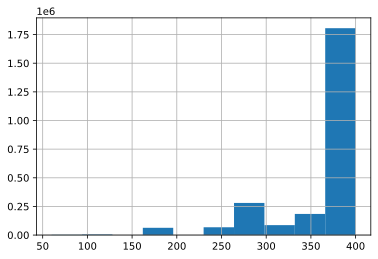

In [34]:
bwdf2['capacity'].hist()


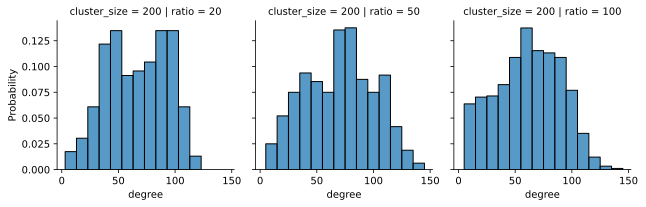

In [113]:
g = sns.FacetGrid(data=df3[(df3.type=='gw') &(df3.cluster_size==200)], col='ratio', row='cluster_size')
g.map_dataframe(sns.histplot, x='degree', stat='probability', cumulative=False, binwidth=10)
#sns.histplot(data=df3[df3.type=='gw'], x='degree', stat='probability', cumulative=True)

In [141]:
v, bins = np.histogram(df3[(df3.type=='relay')&(df3.cluster_size==200)]['antennae'].values, bins=11)
v=(v/sum(v))

pd.DataFrame(np.array(list(zip(bins, [sum(v[:i]) for i in range(len(v))]))), columns=['degree', 'cum_p'])

,degree,cum_p
0,1.000000,0.000000
1,2.090909,0.971609
2,3.181818,0.988950
3,4.272727,0.994515
4,5.363636,0.997000
5,6.454545,0.998492
6,7.545455,0.999339
7,8.636364,0.999718
8,9.727273,0.999895
9,10.818182,0.999968


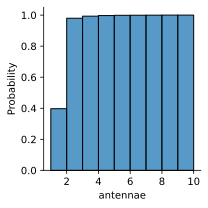

In [116]:
g = sns.FacetGrid(data=df3[(df3.type=='relay')])

g.map_dataframe(sns.histplot, x='antennae', stat='probability', binwidth=1, cumulative=True)

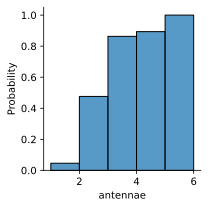

In [117]:
g = sns.FacetGrid(data=df3[(df3.type=='gw')])
g.map_dataframe(sns.histplot, x='antennae', stat='probability', binwidth=1, cumulative=True)

Text(0, 0.5, '$n_a(n)$')

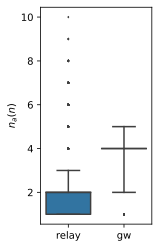

In [53]:

d= df3[(df3.cluster_size == 200) &(df3.type != 'leaf')]#.groupby(['type'])['antennae'].quantile([0.1,0.9])
plt.figure(figsize=(2,4))
sns.boxplot(x="type", y="antennae", data=d, whis=[1, 99], fliersize=1)
plt.xlabel("")
plt.ylabel("$n_a(n)$")


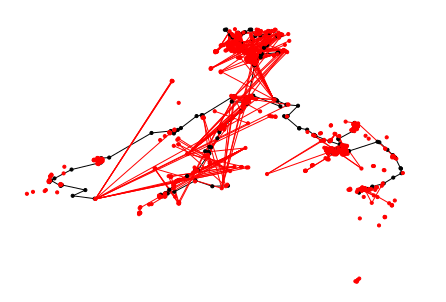

In [93]:
g = graphs[100]
pos = {n:(d['x'],d['y']) for n, d in g[2].nodes(data=True)}
nx.draw(g[2], pos=pos, node_size=10, node_color='black', edge_color='black')
pos = {n:(d['x'],d['y']) for n, d in g[1].nodes(data=True)}
nx.draw(g[1], pos=pos, node_size=10, node_color='red', edge_color='red')

In [119]:
df3.area.unique()

array(['sambuca pistoiese', 'villa basilica', 'borgo a mozzano',
       'castel del piano', 'santa fiora', 'magliano in toscana',
       'porcari', 'roccalbegna', 'fauglia', 'stazzema', 'semproniano'],
      dtype=object)